In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
  
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.feature_selection import SelectKBest, f_regression  
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
ss = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv')


In [2]:
print(train.shape)
train.head()
print(test.shape)
test.head()

(116023, 52)
(29006, 51)


,userChannel,date,browser,device.browserSize,device.browserVersion,deviceType,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,...,trafficSource,sessionId,sessionNumber,sessionStart,userId,locationZone,geoCluster,browserMajor,screenSize,gclIdPresent
0,Social,20170508,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,groups.google.com,1494262567,2,1494262567,59555,8,Region_2,not available in demo dataset,medium,0
1,Organic Search,20170405,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1491433811,1,1491433811,6394,8,Region_1,not available in demo dataset,medium,0
2,Organic Search,20170308,Safari,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1489001815,1,1489001815,38969,8,Region_5,not available in demo dataset,medium,0
3,Referral,20171113,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,docs.google.com,1510593024,30,1510593024,120027,8,Region_2,not available in demo dataset,medium,0
4,Organic Search,20161212,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,(direct),1481559809,1,1481559809,69453,8,Region_3,not available in demo dataset,medium,0


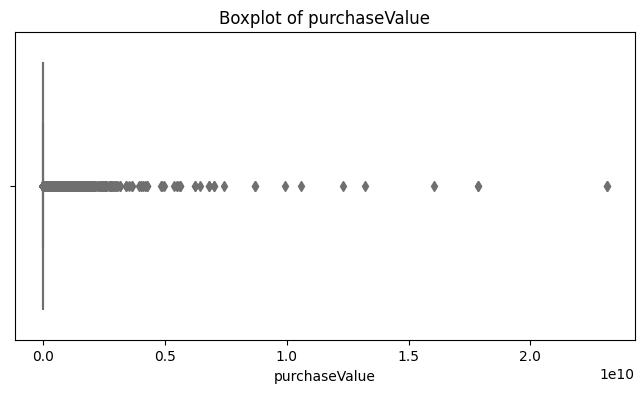

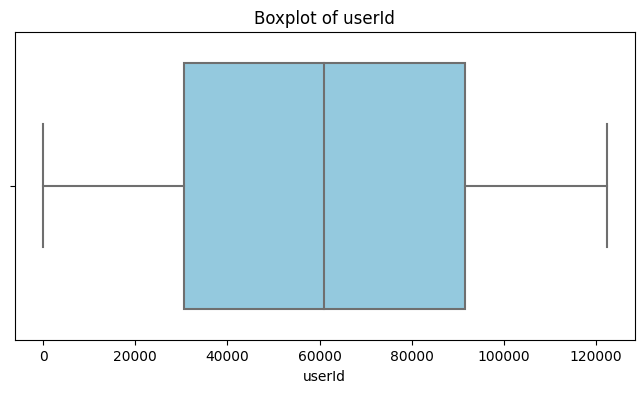

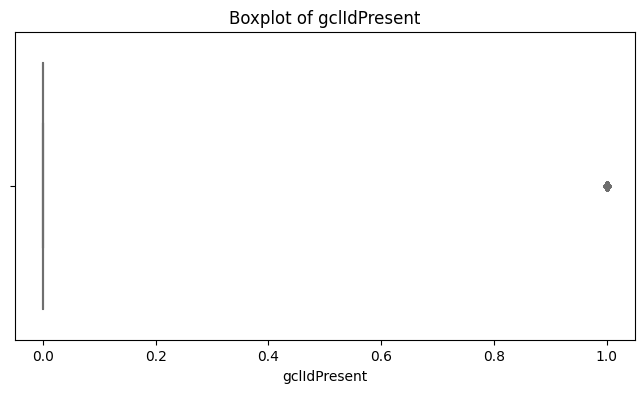

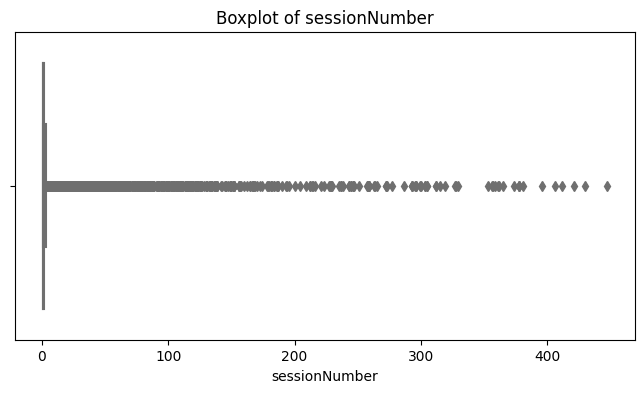

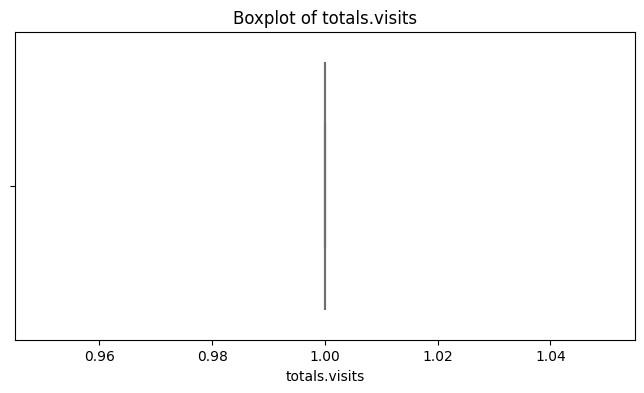

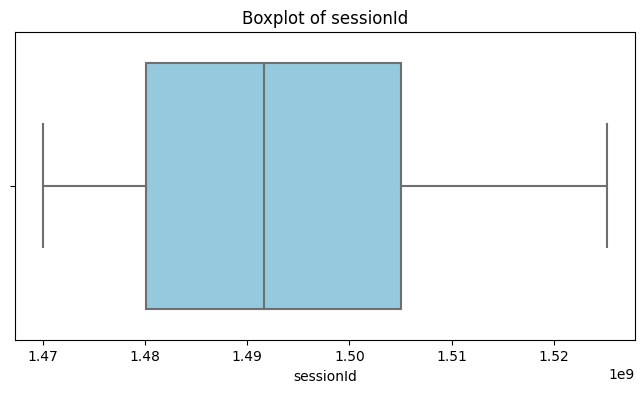

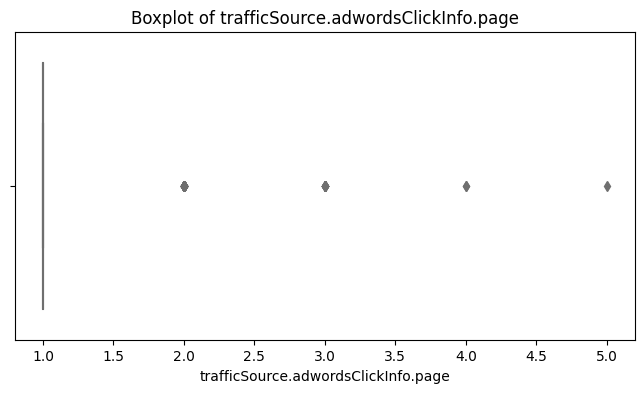

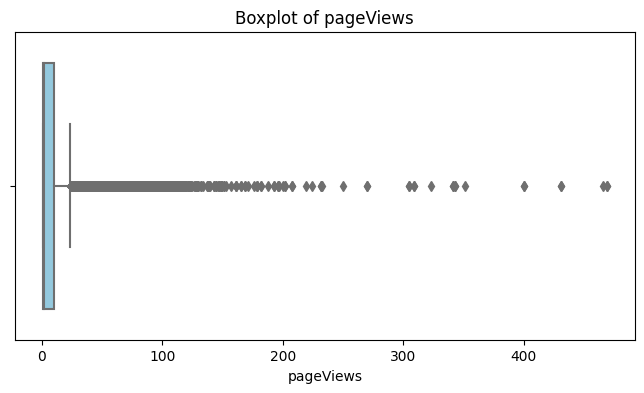

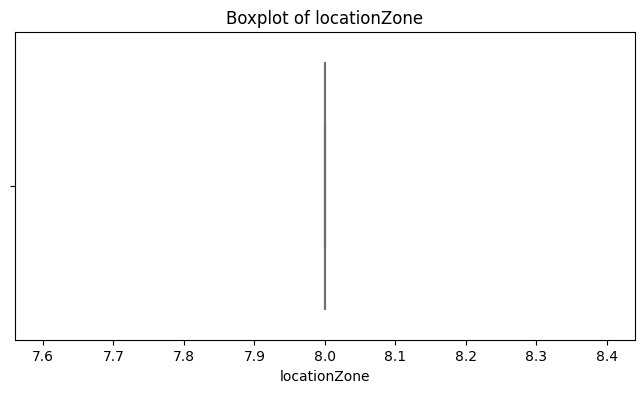

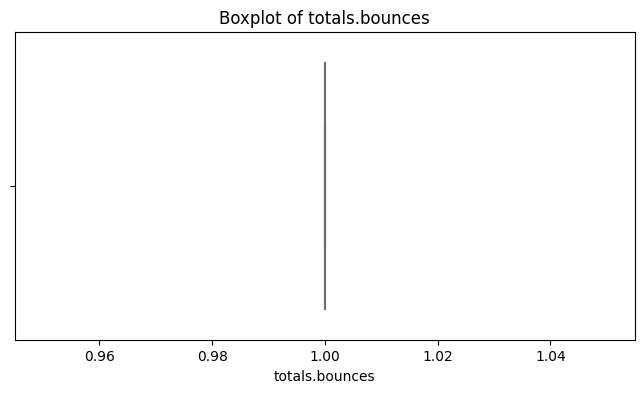

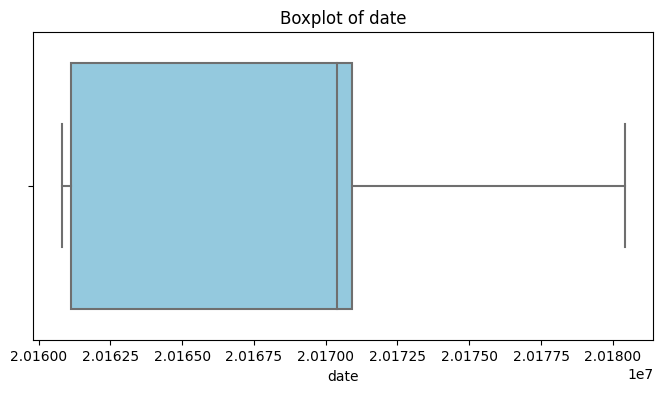

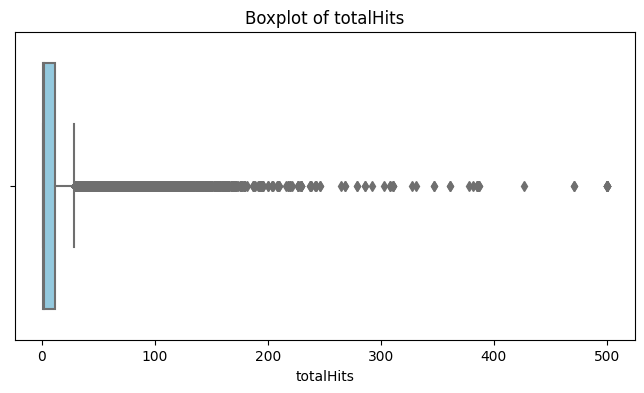

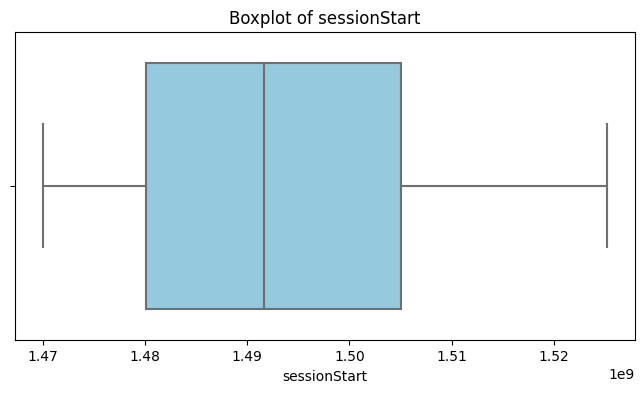

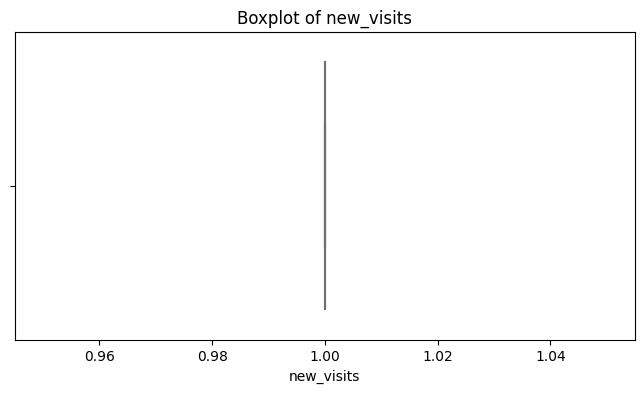

In [3]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.show()

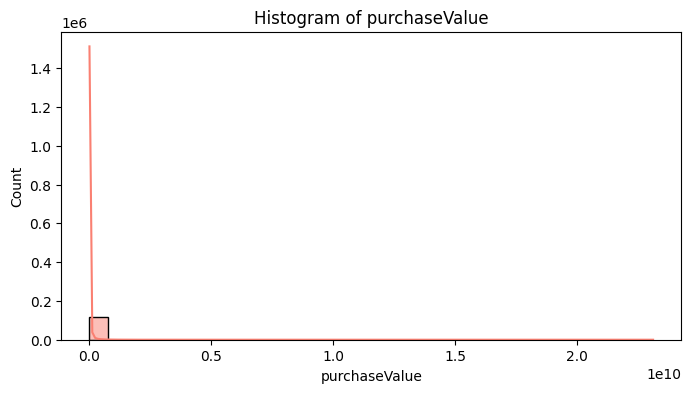

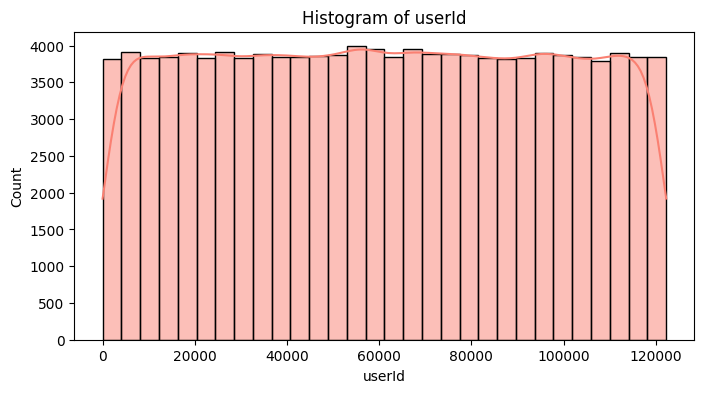

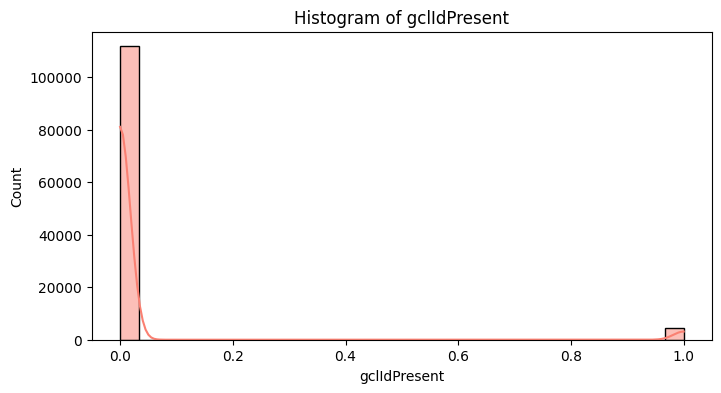

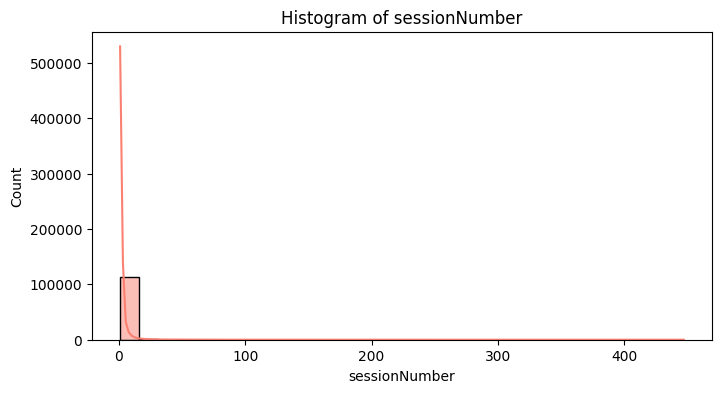

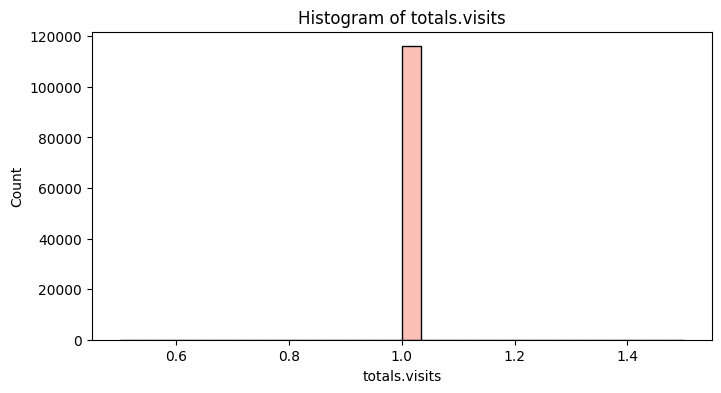

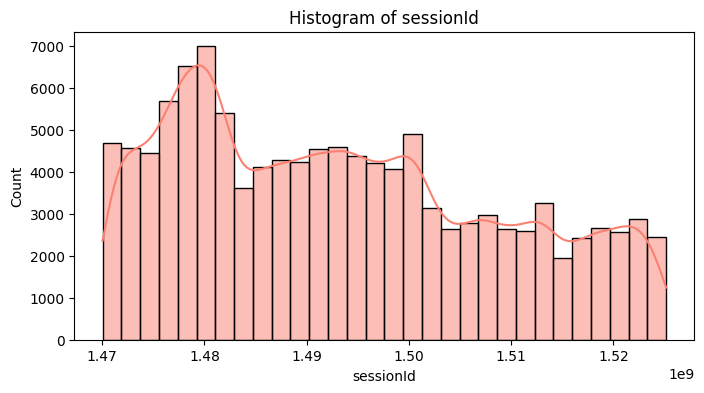

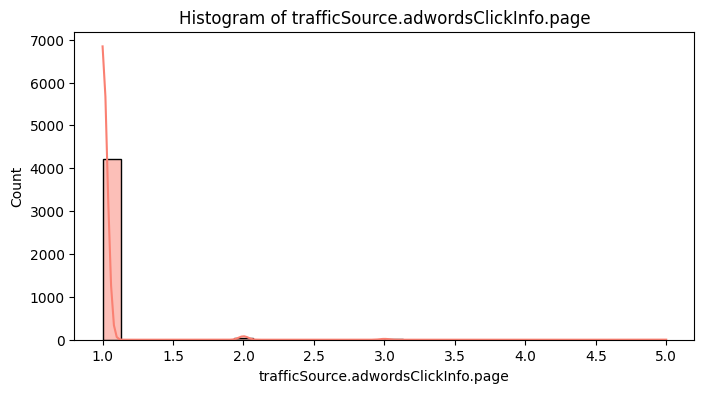

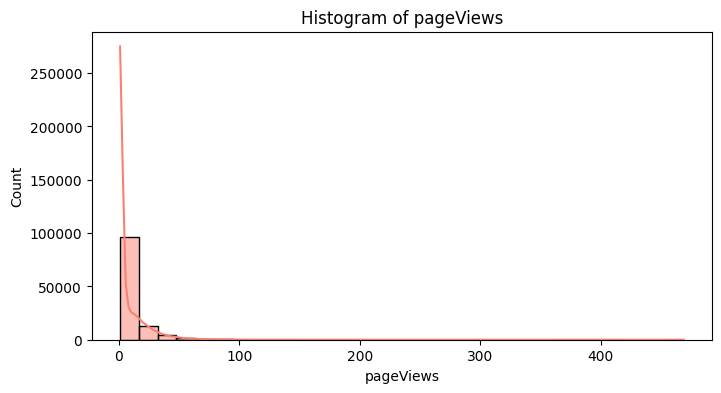

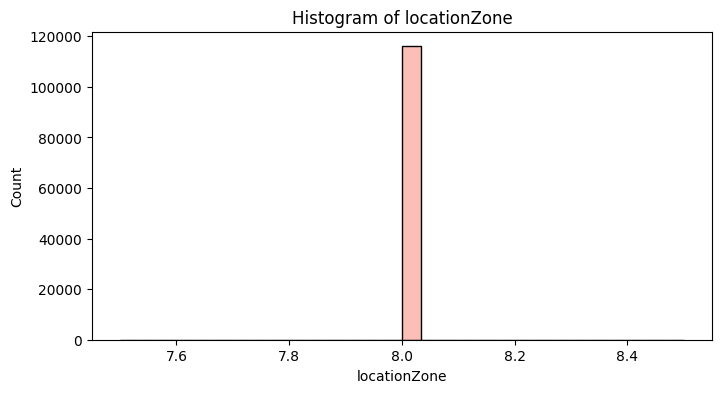

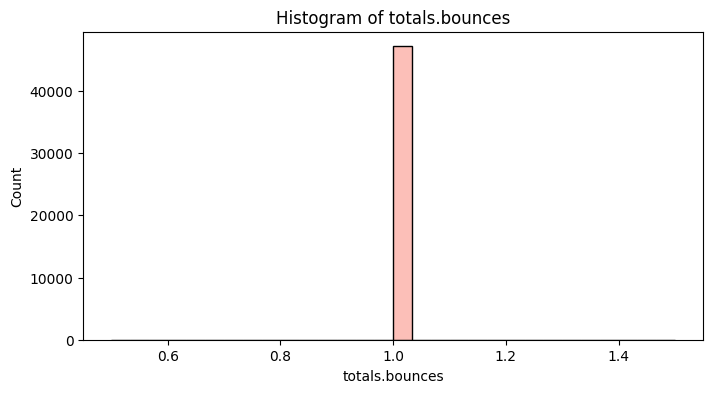

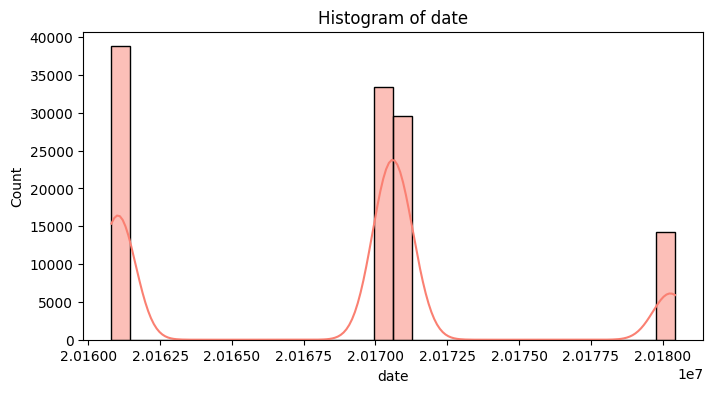

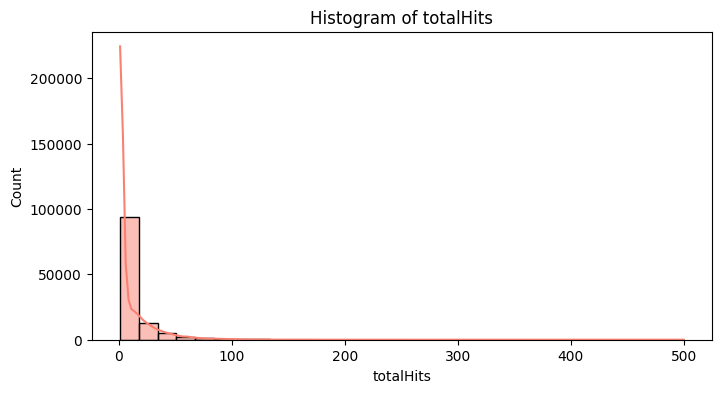

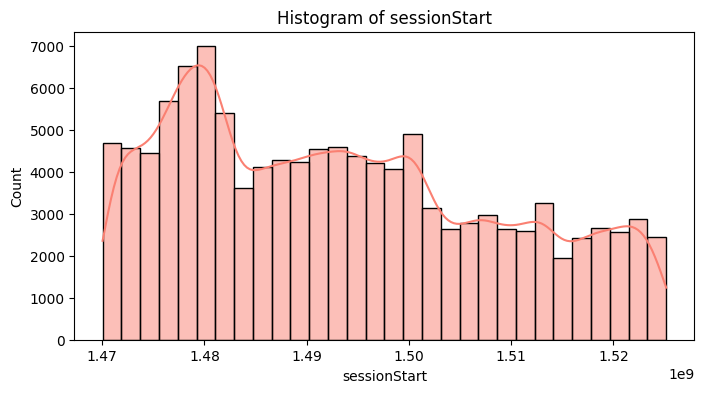

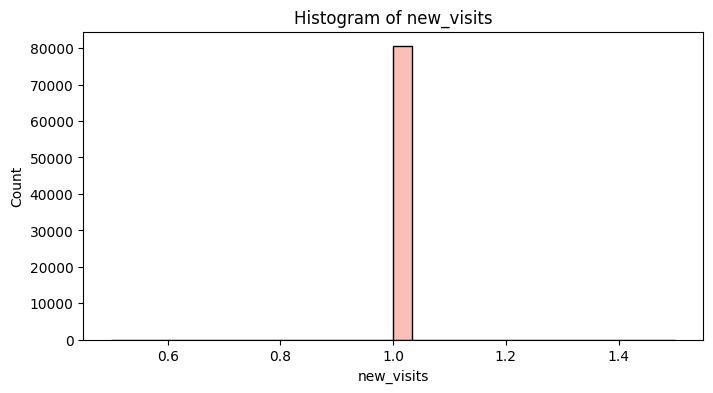

In [4]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[col], bins=30, kde=True, color='salmon')
    plt.title(f'Histogram of {col}')
    plt.show()

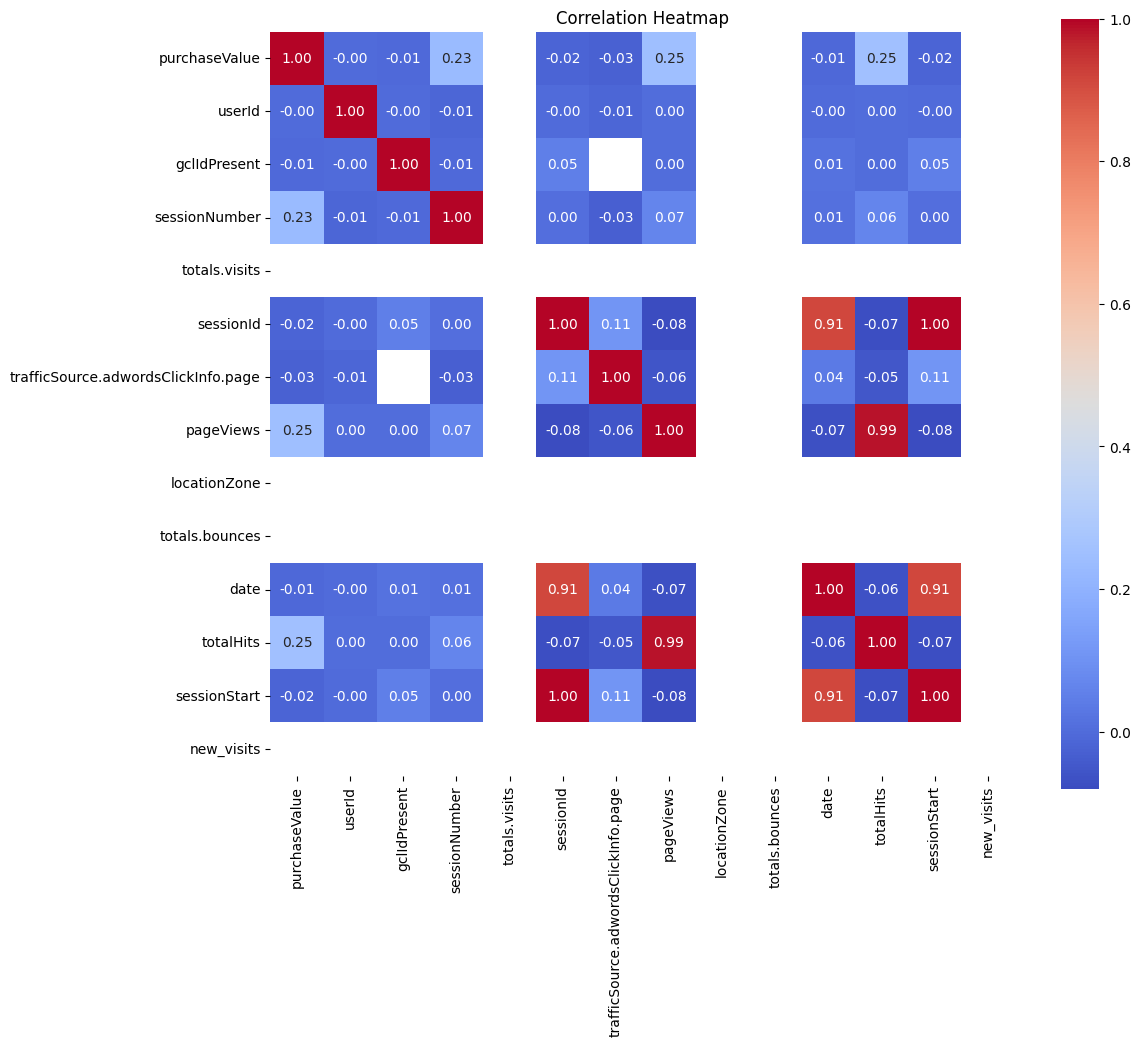

In [5]:
plt.figure(figsize=(12, 10))
corr = train[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
train.columns

Index(['trafficSource.isTrueDirect', 'purchaseValue', 'browser',
       'device.screenResolution', 'trafficSource.adContent',
       'trafficSource.keyword', 'screenSize', 'geoCluster',
       'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding',
       'device.mobileInputSelector', 'userId', 'trafficSource.campaign',
       'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain',
       'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber',
       'device.flashVersion', 'geoNetwork.region', 'trafficSource',
       'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os',
       'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor',
       'locationCountry', 'device.browserSize',
       'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType',
       'geoNetwork.city', 'trafficSource.adwordsClickInfo.page',
       'geoNetwork.metro', 'pageViews', 'locationZone',
      

In [7]:
target_variable = 'purchaseValue'
X_train = train.drop(target_variable, axis=1).copy()
y_train = train[target_variable]
X_test = test.copy()

In [8]:
y_train.head()

0           0.0
1           0.0
2           0.0
3           0.0
4    88950000.0
Name: purchaseValue, dtype: float64

In [9]:
y_train.shape

(116023,)

In [10]:
X_test = test.copy()
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 51 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   browser                                       116023 non-null  object 
 2   device.screenResolution                       116023 non-null  object 
 3   trafficSource.adContent                       2963 non-null    object 
 4   trafficSource.keyword                         44162 non-null   object 
 5   screenSize                                    116023 non-null  object 
 6   geoCluster                                    116023 non-null  object 
 7   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 8   device.mobileDeviceBranding                   116023 non-null  object 
 9   device.mobileInputSelector                    11

In [11]:
missing_counts = X_train.isna().sum()
total_rows = len(X_train)
percent_missing = (missing_counts / total_rows) * 100

missing_summary = pd.DataFrame({
    'Column Name': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing': percent_missing.values
})
  
x = missing_summary[missing_summary['Missing'] > 0]
m = x.sort_values(by='Missing', ascending=False)

print(m)


                                     Column Name  Missing Count    Missing
3                        trafficSource.adContent         113060  97.446196
7            trafficSource.adwordsClickInfo.slot         111742  96.310214
26      trafficSource.adwordsClickInfo.isVideoAd         111742  96.310214
30  trafficSource.adwordsClickInfo.adNetworkType         111742  96.310214
33           trafficSource.adwordsClickInfo.page         111742  96.310214
38                    trafficSource.referralPath          73309  63.184886
0                     trafficSource.isTrueDirect          73133  63.033192
4                          trafficSource.keyword          71861  61.936857
39                                totals.bounces          68875  59.363230
50                                    new_visits          35505  30.601691
35                                     pageViews              8   0.006895


**Since the number of rows are 116023, we have to remove the columns, that have missing values of >95 percentage**

| Column Name                                    | Missing Count | % Missing |
| ---------------------------------------------- | ------------- | --------- |
| `trafficSource.adContent`                      | 113060        | \~97.4%   |
| `trafficSource.adwordsClickInfo.slot`          | 111742        | \~96.3%   |
| `trafficSource.adwordsClickInfo.isVideoAd`     | 111742        | \~96.3%   |
| `trafficSource.adwordsClickInfo.adNetworkType` | 111742        | \~96.3%   |
| `trafficSource.adwordsClickInfo.page`          | 111742        | \~96.3%   |
| `trafficSource.keyword`                        | 71861         | \~61.9%   |
| `trafficSource.isTrueDirect`                   | 73133         | \~63%     |
| `trafficSource.referralPath`                   | 73309         | \~63.1%   |
| `totals.bounces`                               | 68875         | \~59.3%   |
| `new_visits`                                   | 35505         | \~30.6%   |
| `pageViews`                                    | 8             | \~0.0069%   |
---

**And the top 5 has more than 95 %, lets remove them**


In [12]:
high_missing_cols = train.isnull().mean() > 0.95
cols_to_drop = high_missing_cols[high_missing_cols].index.tolist()
X_train.drop(columns=cols_to_drop, inplace=True, errors='ignore')
X_test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

**Remove constant features**

In [13]:
constant_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
X_train.drop(columns=constant_cols, inplace=True)
X_test.drop(columns=constant_cols, inplace=True)

In [14]:
X_train.replace('not available in demo dataset', np.nan, inplace=True)
X_test.replace('not available in demo dataset', np.nan, inplace=True)

In [15]:
X_train['pageViews'].head(20)

0      1.0
1      1.0
2      6.0
3      1.0
4     54.0
5     32.0
6     15.0
7      1.0
8      4.0
9      1.0
10     1.0
11     1.0
12     1.0
13     3.0
14     2.0
15    10.0
16     1.0
17     1.0
18    10.0
19     1.0
Name: pageViews, dtype: float64

In [16]:
X_train[sorted(X_train.columns)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   browser                     116023 non-null  object 
 1   date                        116023 non-null  int64  
 2   device.isMobile             116023 non-null  bool   
 3   deviceType                  116023 non-null  object 
 4   gclIdPresent                116023 non-null  int64  
 5   geoCluster                  116023 non-null  object 
 6   geoNetwork.city             55885 non-null   object 
 7   geoNetwork.continent        116023 non-null  object 
 8   geoNetwork.metro            55885 non-null   object 
 9   geoNetwork.networkDomain    116023 non-null  object 
 10  geoNetwork.region           55885 non-null   object 
 11  geoNetwork.subContinent     116023 non-null  object 
 12  locationCountry             116023 non-null  object 
 13  os            

In [17]:
print(list(X_train.isna().sum())) 

[0, 71861, 0, 0, 0, 0, 0, 0, 60138, 0, 0, 0, 0, 0, 0, 60138, 60138, 8, 73309, 0, 0, 0, 0, 0, 0, 0]


In [18]:
X_train.tail()

,browser,trafficSource.keyword,geoCluster,userId,trafficSource.campaign,geoNetwork.networkDomain,gclIdPresent,sessionNumber,geoNetwork.region,trafficSource,...,geoNetwork.metro,pageViews,trafficSource.referralPath,date,deviceType,userChannel,totalHits,sessionStart,geoNetwork.continent,device.isMobile
116018,Chrome,NaN,Region_3,109014,(not set),domain1,0,1,New York,(direct),...,New York NY,26.0,/,20170717,desktop,Referral,28,1500318402,Americas,False
116019,Chrome,NaN,Region_5,66111,(not set),domain2,0,1,California,(direct),...,San Francisco-Oakland-San Jose CA,1.0,NaN,20161108,desktop,Direct,1,1478624150,Americas,False
116020,Chrome,NaN,Region_1,97614,(not set),domain2,0,2,Delhi,seroundtable.com,...,(not set),1.0,/google-analytics-launches-public-demo-account...,20160805,desktop,Referral,1,1470384216,Asia,False
116021,Chrome,(not provided),Region_5,71050,(not set),domain1,0,1,Tennessee,google,...,Nashville TN,2.0,NaN,20171002,desktop,Organic Search,2,1506953297,Americas,False
116022,Chrome,(not provided),Region_5,39773,(not set),domain2,0,4,NaN,google,...,NaN,73.0,NaN,20170730,mobile,Organic Search,102,1501474532,Americas,True


In [19]:
for df in [X_train, X_test]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['weekday'] = df['date'].dt.weekday
        df['quarter'] = df['date'].dt.quarter
        df['is_weekend'] = df['date'].dt.weekday >= 5
        df.drop(columns='date', inplace=True, errors='ignore')
        
for df in [X_train, X_test]:
    if 'pageViews' in df.columns and 'totalHits' in df.columns:
        df['pageviews_per_hit'] = df['pageViews'] / (df['totalHits'] + 1)
        df['hit_depth'] = df['totalHits'] / (df['pageViews'] + 1)

for df in [X_train, X_test]:
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)


In [20]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

In [21]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
X_train_encoded[cat_cols] = X_train_encoded[cat_cols].fillna('unknown')
X_test_encoded[cat_cols] = X_test_encoded[cat_cols].fillna('unknown')

In [22]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_encoded[cat_cols] = encoder.fit_transform(X_train_encoded[cat_cols].astype(str))
X_test_encoded[cat_cols] = encoder.transform(X_test_encoded[cat_cols].astype(str))

In [23]:
X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce')
X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce')

In [24]:
X_train_encoded.fillna(-999, inplace=True)
X_test_encoded.fillna(-999, inplace=True)

In [25]:
selector = SelectKBest(score_func=f_regression, k=30)
X_train_kbest = selector.fit_transform(X_train_encoded, y_train)
selected_feats = X_train_encoded.columns[selector.get_support()].tolist()

In [26]:
X_train = X_train_encoded[selected_feats]
X_test = X_test_encoded[selected_feats]
X_train.fillna(-999, inplace=True)
X_test.fillna(-999, inplace=True)

In [27]:
from sklearn.model_selection import KFold
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
"""
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Assume x_tr is your training dataframe
num_features = x_tr.select_dtypes(include=np.number).columns.tolist()

num_pipeline = Pipeline([ 
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features)
])
"""

"\nimport numpy as np\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.compose import ColumnTransformer\n\n# Assume x_tr is your training dataframe\nnum_features = x_tr.select_dtypes(include=np.number).columns.tolist()\n\nnum_pipeline = Pipeline([ \n    ('imputer', SimpleImputer(strategy='median')),\n    ('scaler', StandardScaler())\n])\n\npreprocessor = ColumnTransformer([\n    ('num', num_pipeline, num_features)\n])\n"

In [29]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    results[name] = {
        'rmse_mean': -scores.mean(),
        'rmse_std': scores.std()
    }
    print(f"{name}: RMSE = {-scores.mean():.4f} ± {scores.std():.4f}") 
    
best_model_name = min(results.keys(), key=lambda x: results[x]['rmse_mean'])
final_model = models[best_model_name]
final_model.fit(X_train, y_train)


pred_val = final_model.predict(X_val) 
print("  RMSE :", mean_squared_error(y_val, pred_val, squared=False),"\n  MAE  :", mean_absolute_error(y_val, pred_val), "\n  R²   :", r2_score(y_val, pred_val))


Linear Regression: RMSE = 190083543.9298 ± 21053889.1444


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1487e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.14981e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15209e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.15399e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning

Ridge: RMSE = 190083514.1147 ± 21053955.2218


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+21, tolerance: 2.739e+17
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+21, tolerance: 3.025e+17
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+21, tolerance: 3.170e

Lasso: RMSE = 190082575.1680 ± 21054739.1710
Random Forest: RMSE = 127699813.5009 ± 17531991.2680
Gradient Boosting: RMSE = 134804441.1776 ± 17861779.0243
XGBoost: RMSE = 131935739.0588 ± 17867100.1627
LightGBM: RMSE = 158566131.0631 ± 16108341.8799
  RMSE : 76487025.28974359 
  MAE  : 8528306.93815988 
  R²   : 0.8762333822667965


In [30]:
X_val.shape 

(23205, 30)

In [31]:
print(best_model_name) 

Random Forest


**RFR is the best model, so save it and submit**

In [32]:
pred_test = final_model.predict(X_test)

submission = pd.DataFrame({
    'id': ss['ID'],
    target_variable: pred_test
})
submission.to_csv('submission.csv', index=False)
print("submission.csv saving done :)")

submission.csv saving done :)
